In [41]:
# IMPORT ALL NECESSARY PACKAGES

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
import pandas as pd
import numpy as np
import json

In [42]:
# READ THE TRAIN/TEST/VAL DATASETS:

from os import listdir
from os.path import isfile, join

path = "../data/"
files = [f for f in listdir(path) if isfile(join(path, f))]

train_movies_df = None
for f in files:
    if 'train' in f:
        print('Reading train file...', f)
        df = pd.read_csv(path + "/" + f)
        try:
            train_movies_df = pd.concat([train_movies_df, df])
        except:
            # First file
            train_movies_df = df
            
    if 'test' in f:
        print('Reading test file...', f)
        test_movies_df = pd.read_csv(path + "/" + f)
    
    if 'validation' in f:
        print('Reading validation file...', f)
        validation_movies_df = pd.read_csv(path + "/" + f)
        
print('Train size:', train_movies_df.shape[0])
display(train_movies_df.head(10))
display(train_movies_df.info())

Reading test file... test_hidden.csv
Reading train file... train-1.csv
Reading train file... train-2.csv
Reading train file... train-3.csv
Reading train file... train-4.csv
Reading train file... train-5.csv
Reading train file... train-6.csv
Reading train file... train-7.csv
Reading train file... train-8.csv
Reading validation file... validation_hidden.csv
Train size: 7959


,Unnamed: 0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label
0,4,tt0010600,The Doll,Die Puppe,1919,\N,66,1898.0,True
1,7,tt0011841,Way Down East,Way Down East,1920,\N,145,5376.0,True
2,9,tt0012494,Déstiny,Der müde Tod,1921,\N,97,5842.0,True
3,25,tt0015163,The Navigator,The Navigator,1924,\N,59,9652.0,True
4,38,tt0016220,The Phantom of the Opera,The Phantom of the Opera,1925,\N,93,17887.0,True
5,42,tt0016630,Báttling Bútlér,Battling Butler,1926,\N,77,3285.0,True
6,81,tt0021015,Juno and the Paycock,NaN,1929,\N,85,2275.0,False
7,118,tt0023973,Thé Éáglé ánd thé Háwk,NaN,1933,\N,73,NaN,True
8,119,tt0023986,Émplớyéés' Éntráncé,NaN,1933,\N,75,NaN,True
9,123,tt0024184,The Invisible Man,The Invisible Man,1933,\N,71,33562.0,True


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7959 entries, 0 to 992
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      7959 non-null   int64  
 1   tconst          7959 non-null   object 
 2   primaryTitle    7959 non-null   object 
 3   originalTitle   3971 non-null   object 
 4   startYear       7959 non-null   object 
 5   endYear         7959 non-null   object 
 6   runtimeMinutes  7959 non-null   object 
 7   numVotes        7169 non-null   float64
 8   label           7959 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 567.4+ KB


None

In [3]:
df = pd.read_csv("../data/train-1.csv")
len(df)
df[df['tconst']=='tt0023986']

,Unnamed: 0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label
8,119,tt0023986,Émplớyéés' Éntráncé,NaN,1933,\N,75,NaN,True


In [4]:
# GET THE WRITINGS INFORMATION:

file = f = open('../data/writing.json')
list_writings = json.load(file)

# list_2df = [[dict_['movie'], dict_['writer']] for dict_ in list_writings]
# df_writings = pd.DataFrame(list_2df, columns=['movie', 'writer'])
df_writings = pd.DataFrame(list_writings, columns=['movie', 'writer'])

print('Writings size:', df_writings.size)
print('Unique writers:', len(df_writings['writer'].unique()))
display(df_writings.head(5))

Writings size: 44856
Unique writers: 15248


,movie,writer
0,tt0003740,nm0195339
1,tt0003740,nm0515385
2,tt0003740,nm0665163
3,tt0003740,nm0758215
4,tt0008663,nm0406585


In [5]:
# A BIT OF EDA:
print('Votes mean:', train_movies_df['numVotes'].mean())
print('Votes median:', train_movies_df['numVotes'].median())
print('Votes min/max:', train_movies_df['numVotes'].min(), train_movies_df['numVotes'].max())
print('---')

train_movies_df.astype({'startYear': 'int32', 'endYear': 'int32'}, errors='ignore').dtypes


print('Min/max start year:', train_movies_df['startYear'].min(), train_movies_df['startYear'].max())
print('Min/max end year:', train_movies_df['endYear'].min(), train_movies_df['startYear'].max())

Votes mean: 30873.026905829596
Votes median: 3315.0
Votes min/max: 1001.0 2503641.0
---
Min/max start year: 1924 \N
Min/max end year: 1931 \N


In [6]:
# train_movies_df[train_movies_df['endYear']=='\\N'].apply(train_movies_df['startYear'])
train_movies_df.startYear.replace('\\N',df.endYear,inplace=True)

ValueError: Series.replace cannot use dict-value and non-None to_replace

In [7]:
train_movies_df['endYear']

0      \N
1      \N
2      \N
3      \N
4      \N
       ..
988    \N
989    \N
990    \N
991    \N
992    \N
Name: endYear, Length: 993, dtype: object

In [8]:
def check_int(value):
    try:
        int(value)
        return int(value)
    except ValueError:
        return 0
train_movies_df['endYear'] = train_movies_df['endYear'].apply(check_int)

# Multi-label classification for genre extraction

https://imdb-api.com/en/API/Title/k_2qlsgnp9/tt0015224

['id', 'title', 'originalTitle', 'fullTitle', 'type', 'year', 'image', 'releaseDate', 'runtimeMins', 'runtimeStr', 'plot', 'plotLocal', 'plotLocalIsRtl', 'awards', 'directors', 'directorList', 'writers', 'writerList', 'stars', 'starList', 'actorList', 'fullCast', 'genres', 'genreList', 'companies', 'companyList', 'countries', 'countryList', 'languages', 'languageList', 'contentRating', 'imDbRating', 'imDbRatingVotes', 'metacriticRating', 'ratings', 'wikipedia', 'posters', 'images', 'trailer', 'boxOffice', 'tagline', 'keywords', 'keywordList', 'similars', 'tvSeriesInfo', 'tvEpisodeInfo', 'errorMessage']

In [209]:
import http.client
import mimetypes
import json

In [210]:
conn = http.client.HTTPSConnection("imdb-api.com", 443)
api_key = 'k_2qlsgnp9'
payload = ''
headers = {}

In [211]:
def get_movie_info(movie_id):
    conn.request("GET", "/en/API/Title/"+api_key+"/"+movie_id, payload, headers)
    res = conn.getresponse()
    data = res.read()
    data_json = data.decode("utf-8")
    return json.loads(data_json)

def get_genres(movie_id):
    try:
        info = get_movie_info(movie_id)
        return info['genres']
    except Exception as e:
        print(e.message, e.args)
        return e.args

In [64]:
movie_id = 'tt0015224' # Example: Peter Pan
get_genres(movie_id)

'Adventure, Family, Fantasy'

In [111]:
movies_wGenre = train_movies_df
movies_wGenre['genre'] = movies_wGenre['tconst'].apply((lambda x: get_genres(x)))
movies_wGenre.head(5)

,Unnamed: 0,tconst,primaryTitle,originalTitle,startYear,endYear,runtimeMinutes,numVotes,label,genre
0,29,tt0015224,Peter Pan,NaN,1924,0,105,1042.0,True,"Adventure, Family, Fantasy"
1,35,tt0015864,The Gold Rush,NaN,1925,0,95,107475.0,True,"Adventure, Comedy, Drama"
2,37,tt0016029,The Little Colonel,NaN,1935,0,81,1646.0,True,"Comedy, Family, Musical"
3,82,tt0021309,The Story of the Fox,Le roman de Renard,1937,0,63,NaN,True,"Animation, Adventure, Comedy"
4,93,tt0022395,The Skin Game,NaN,1931,0,85,NaN,False,Drama


In [224]:
display(movies_wGenre.shape[0])
display(movies_wGenre[pd.isna(movies_wGenre['genre'])].shape[0])

918

818

In [225]:
list_genres = movies_wGenre[[not i for i in pd.isna(movies_wGenre['genre'])]]['genre']
gens = [gen.strip() for movie in list_genres for gen in movie.split(',')]
print('Num of genres: ', len(set(gens)))
set(gens)

Num of genres:  19


{'Action',
 'Adventure',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

## Genre from another API

https://api.themoviedb.org/3/genre/movie/list?api_key=40f5afa6d3b4da3ef1e32a4e4bb3fe20

In [25]:
import http.client
import mimetypes
import json

In [46]:
conn = http.client.HTTPSConnection("api.themoviedb.org")
api_key = '40f5afa6d3b4da3ef1e32a4e4bb3fe20'
payload = ''
headers = {
    'Content-Type': 'application/json;charset=utf-8',
    'Authorization': 'Bearer <<access_token>>'
}

In [48]:
conn.request("GET", "/3/movie/tt0015224?api_key="+api_key, payload, headers)
res = conn.getresponse()
data = res.read()
data_json = data.decode("utf-8")
json.loads(data_json)

In [47]:
def get_movie_info(movie_id):
    conn.request("GET", "/3/movie/"+movie_id+"?api_key="+api_key, payload, headers)
    res = conn.getresponse()
    data = res.read()
    data_json = data.decode("utf-8")
    return json.loads(data_json)

get_movie_info('tt0015224')

{'adult': False,
 'backdrop_path': '/43vkdSbAd3n8c0RyOi8KR9UTEoY.jpg',
 'belongs_to_collection': None,
 'budget': 0,
 'genres': [{'id': 10751, 'name': 'Family'},
  {'id': 12, 'name': 'Adventure'},
  {'id': 14, 'name': 'Fantasy'}],
 'homepage': '',
 'id': 120672,
 'imdb_id': 'tt0015224',
 'original_language': 'en',
 'original_title': 'Peter Pan',
 'overview': 'Peter Pan enters the nursery of the Darling children and, with the help of fairy dust, leads them off to Never Never Land, where they meet the nefarious Captain Hook.',
 'popularity': 3.262,
 'poster_path': '/3JJVzUGwq3KXkBelai6tykQ33fl.jpg',
 'production_companies': [{'id': 29729,
   'logo_path': None,
   'name': 'Famous Players-Lasky Corporation',
   'origin_country': 'US'},
  {'id': 4,
   'logo_path': '/fycMZt242LVjagMByZOLUGbCvv3.png',
   'name': 'Paramount',
   'origin_country': 'US'}],
 'production_countries': [{'iso_3166_1': 'US',
   'name': 'United States of America'}],
 'release_date': '1924-12-29',
 'revenue': 0,
 'runti

In [62]:
info_dict = {}
count = 0
for row in train_movies_df.iterrows():
    movie_id = row[1]['tconst']
    info_dict[movie_id] = get_movie_info(movie_id)
    count +=1 
    if count%10 == 0:
        print(count)
info_dict

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

{'tt0010600': {'adult': False,
  'backdrop_path': '/pXRMcqWslm3exEVkBTHNQYNXjz6.jpg',
  'belongs_to_collection': None,
  'budget': 0,
  'genres': [{'id': 35, 'name': 'Comedy'}, {'id': 14, 'name': 'Fantasy'}],
  'homepage': '',
  'id': 48256,
  'imdb_id': 'tt0010600',
  'original_language': 'de',
  'original_title': 'Die Puppe',
  'overview': 'The misadventures of an effete young man who must get married in order to inherit a fortune. He opts to purchase a remarkably lifelike doll and marry it instead, not realizing that the doll is actually the puppet-maker’s flesh-and-blood daughter in disguise.',
  'popularity': 4.861,
  'poster_path': '/7SAZwSJg4eocvQUguRUzHNfbQ9k.jpg',
  'production_companies': [{'id': 12950,
    'logo_path': None,
    'name': 'Projektions-AG Union (PAGU)',
    'origin_country': ''}],
  'production_countries': [{'iso_3166_1': 'DE', 'name': 'Germany'}],
  'release_date': '1919-12-05',
  'revenue': 0,
  'runtime': 66,
  'spoken_languages': [{'english_name': 'No Langu

In [64]:
# Save the raw data as json
json_object = json.dumps(info_dict)
with open("info_movies_json2.json", "w") as outfile:
    outfile.write(json_object)

In [164]:
# Read the downloaded json file
file_name = 'info_movies_json.json'

with open(file_name) as json_file:
    movies_info = json.load(json_file)

In [165]:
# Convert to dataframe:
list_movies_info = [val for val in movies_info.values()]
df_movies_info = pd.DataFrame(list_movies_info)

# Delete empty rows:
df_movies_info.dropna(subset=['imdb_id'], inplace=True)
# Set imdb_id as index:
df_movies_info = df_movies_info.set_index('imdb_id')


In [166]:
# GET GENRES:
def get_genres(list_genres):
    try:
        list_processed = [gen['name'] for gen in list_genres]
        return list_processed
    except:
        return list_genres

df_movies_info['genre_list'] = df_movies_info['genres'].apply((lambda x: get_genres(x)))

In [167]:
# GET PRODUCTION COMPANIES
def get_production_names(list_production):
    try:
        list_processed = [prod['name'] for prod in list_production]
        return list_processed
    except:
        return list_production

df_movies_info['production_list'] = df_movies_info['production_companies'].apply((lambda x: get_production_names(x)))

In [168]:
# GET PRODUCTION COUNTRIES
def get_production_countries(list_production):
    try:
        list_processed = [prod['iso_3166_1'] for prod in list_production]
        return list_processed
    except:
        return list_production


df_movies_info['production_countr_list'] = df_movies_info['production_countries'].apply((lambda x: get_production_countries(x)))

In [169]:
# GET SPOKEN LANGUAGE:
def get_spoken_language(list_language):
    try:
        list_processed = [lan['iso_639_1'] for lan in list_language if lan['iso_639_1'] != 'xx' ]
        return list_processed
    except:
        return list_production
    
df_movies_info['spoken_language_list'] = df_movies_info['spoken_languages'].apply((lambda x: get_spoken_language(x)))

In [170]:
# REMOVE UNNECESSARY COLUMNS:
df_movies_info = df_movies_info.drop(columns=['success', 'status_code', 'status_message'])
df_movies_info = df_movies_info.drop(columns=['backdrop_path', 'poster_path', 'homepage', 'status'])

# REMOVE PROCESSED COLUMNS:
df_movies_info = df_movies_info.drop(columns=['production_countries', 'spoken_languages', 'genres'])

In [171]:
df_movies_info.head(5)

,adult,belongs_to_collection,budget,id,original_language,original_title,overview,popularity,production_companies,release_date,...,runtime,tagline,title,video,vote_average,vote_count,genre_list,production_list,production_countr_list,spoken_language_list
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0010600,False,None,0.0,48256.0,de,Die Puppe,The misadventures of an effete young man who m...,4.861,"[{'id': 12950, 'logo_path': None, 'name': 'Pro...",1919-12-05,...,66.0,,The Doll,False,7.3,60.0,"[Comedy, Fantasy]",[Projektions-AG Union (PAGU)],[DE],[]
tt0011841,False,None,0.0,31509.0,en,Way Down East,A naive country girl is tricked into a sham ma...,7.617,"[{'id': 4759, 'logo_path': None, 'name': 'D.W....",1920-09-03,...,145.0,A simple story for plain people.,Way Down East,False,7.0,70.0,"[Drama, Action, Romance]","[D.W. Griffith Productions, United Artists]",[US],[]
tt0012494,False,None,0.0,29267.0,de,Der müde Tod,As a young couple stops and rests in a small v...,7.593,"[{'id': 6762, 'logo_path': None, 'name': 'Decl...",1921-10-06,...,105.0,Love is Stronger Than Death,Destiny,False,7.5,107.0,"[Drama, Fantasy, Thriller]",[Decla-Bioscop],[DE],[de]
tt0015163,False,None,0.0,32318.0,en,The Navigator,The wealthy and impulsive Rollo Treadway decid...,7.881,"[{'id': 12190, 'logo_path': None, 'name': 'Bus...",1924-09-28,...,65.0,"Hurry! Hurry! Throw out the ""laff"" line!",The Navigator,False,7.3,152.0,"[Action, Comedy, Romance]",[Buster Keaton Productions],[US],[]
tt0016220,False,None,0.0,964.0,en,The Phantom of the Opera,"A grotesquely disfigured composer known as ""Th...",12.830,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...",1925-09-22,...,101.0,The greatest horror film of modern cinema!,The Phantom of the Opera,False,7.2,243.0,"[Drama, Horror]",[Universal Pictures],[US],[]


In [ ]:
df_movies_info.to_csv('movies_info.csv', sep = ';')  

# Influence of startYear

<AxesSubplot:xlabel='startYear'>

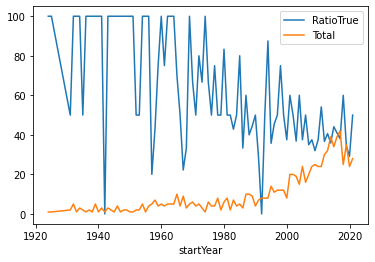

In [204]:
# train_moviesa
movies_true = train_movies_df[train_movies_df['label']==True]
movies_false = train_movies_df[train_movies_df['label']==False]

count_perYear_true = movies_true.groupby(by="startYear").count()[['label']]
count_perYear_true = count_perYear_true.rename(columns={"label": "True"})
count_perYear_false = movies_false.groupby(by="startYear").count()[['label']]
count_perYear_false = count_perYear_false.rename(columns={"label": "False"})

result = pd.concat([count_perYear_true, count_perYear_false], axis=1)
result = result.fillna(0)
result['Total'] = result['True'] + result['False']
result['RatioTrue'] = (result['True'] / result['Total'])*100

result = result.drop(['\\N'], axis=0)
result.index = result.index.map(int) 
result = result.sort_index()

result['RatioTrue'].plot.line(legend=True)
result['Total'].plot.line(legend=True)

# MLlib

## Gradient Boosting Trees

In [219]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [217]:
# Load and parse the data file, converting it to a DataFrame.
data = spark.read.format("libsvm").load("iris_scale.txt")
data

NameError: name 'spark' is not defined

In [ ]:

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

## One vs rest

In [216]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# load data file.
inputData = spark.read.format("libsvm") \
    .load("data/mllib/sample_multiclass_classification_data.txt")

In [ ]:
# generate the train/test split.
(train, test) = inputData.randomSplit([0.8, 0.2])

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train)

# score the model on test data.
predictions = ovrModel.transform(test)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))